In [1]:
import time
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import warnings
warnings.filterwarnings("ignore")

from scipy import sparse
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB ,GaussianNB
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score ,log_loss ,accuracy_score ,confusion_matrix

from sklearn.pipeline import make_union
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted

In [2]:
train=pd.read_csv("Data/Train_Feature-Engineering_Cleaned-Cmnt.csv")
train.head(2)

,id,Cleaned_Comment,length,caps,word_length,exclamation,question,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explanation why the edits made under my userna...,0.420415,0.083521,0.043750,0.000000,0.004785,0,0,0,0,0,0,1
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0.157439,0.108351,0.065625,0.002309,0.000000,0,0,0,0,0,0,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131756 entries, 0 to 131755
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               131756 non-null  object 
 1   Cleaned_Comment  131740 non-null  object 
 2   length           131756 non-null  float64
 3   caps             131756 non-null  float64
 4   word_length      131291 non-null  float64
 5   exclamation      131756 non-null  float64
 6   question         131756 non-null  float64
 7   toxic            131756 non-null  int64  
 8   severe_toxic     131756 non-null  int64  
 9   obscene          131756 non-null  int64  
 10  threat           131756 non-null  int64  
 11  insult           131756 non-null  int64  
 12  identity_hate    131756 non-null  int64  
 13  clean            131756 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 14.1+ MB


In [4]:
# As (131756 - 131740) Comments are NULL
train["Cleaned_Comment"].fillna("unknown",inplace=True)

## Defining Some Functions

In [5]:
############################### NVSVM #####################################

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False):
        self.C = C
        self.dual = dual

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def log_count_ratio(x, y):
            x = sparse.csr_matrix(x)
            p = abs(x[np.where(y==1)].sum(axis=0))
            p = p + 1
            p = p / np.sum(p)
            q = abs(x[np.where(y==0)].sum(axis=0))
            q = q + 1
            q = q / np.sum(q)
            return np.log(p/q)
    
        self._r = sparse.csr_matrix(log_count_ratio(x, y))
        x_nb = x.multiply(self._r)
        self._clf = LinearSVC(C=self.C, dual=self.dual).fit(x_nb, y)
        return self

####################### Multi Label Classification #########################

def Train_Model(model , x_train , x_test):
    t=time.time()
    Accuracy_scores=[];F1_scores=[];tp=0;fp=0;fn=0
    print("\n","-"*15,model,"-"*15)
    for label in targets:        
        model.fit(x_train.tocsr(), y_train[label]) 
        y_pred = model.predict(x_test)
        c=confusion_matrix(y_test[label], y_pred)
        tp+=c[1][1];fp+=c[0][1];fn+=c[1][0]
        Accuracy_scores.append(accuracy_score(y_test[label], y_pred))
        F1_scores.append(f1_score(y_test[label], y_pred))
        print('Training F1_Score for',label,'is',round(f1_score(y_test[label], y_pred),4))
    print()
    print("Average Accuracy",round(sum(Accuracy_scores)/len(targets)*100,3),"% .")
    print("Macro F1_score",round(sum(F1_scores)/len(targets),4),".")
    print("Micro F1_score",round(2*tp/(2*tp+fp+fn),4),".")
    print("Time Taken =",time.time()-t)
    
######################### Plots Confusion Matrices #########################    

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()    

####################### Plots HyperParameter Tuning #########################    
    
def plot_hyperparameter_tuning(C,f1_scores):
    fig, ax = plt.subplots()
    ax.plot(C, f1_scores, c='r')
    for i, txt in enumerate(np.round(f1_scores,4)):
        ax.annotate((C[i],np.round(txt,3)), (C[i],f1_scores[i]))
    plt.grid()
    plt.title("F1 Score for each C")
    plt.xlabel("C i's")
    plt.ylabel("F1 Score")
    plt.show()   

## Random train test split( 70:30) 

In [6]:
X_train ,X_test ,y_train ,y_test = train_test_split(train.iloc[:,1:7] ,train.iloc[:,7:], \
                                                 test_size=0.3)
targets = list(y_train.columns)

## Vectorizing the Data ( Tf-IDF )

In [7]:
vect = TfidfVectorizer(max_features=5000 , analyzer='word')
x_train = vect.fit_transform(X_train["Cleaned_Comment"])
x_test = vect.transform(X_test["Cleaned_Comment"])

## Merging  Feature Engineering 
<p>
The Tf-IDF vector is merged with remaining features i.e <b>length , caps , word_length , exclamation , question</b> 
<p>

In [8]:
# Function for Merging Features

def merge_features(comment_text_vector , data , engineered_features):
    new_features = sparse.csr_matrix(data[engineered_features].values)
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text_vector , new_features])

In [9]:
# Merging the Features

x_train_feature = merge_features(x_train , X_train.iloc[:,1:], X_test.columns[1:])
x_test_feature = merge_features(x_test , X_test.iloc[:,1:], X_test.columns[1:])

## MODELLING

In [10]:
models = [LogisticRegression() ,LinearSVC() ,MultinomialNB() ,NbSvmClassifier()]
for model in models:
    Train_Model(model , x_train , x_test )


 --------------- LogisticRegression() ---------------
Training F1_Score for toxic is 0.7374
Training F1_Score for severe_toxic is 0.3669
Training F1_Score for obscene is 0.7542
Training F1_Score for threat is 0.2561
Training F1_Score for insult is 0.657
Training F1_Score for identity_hate is 0.2918
Training F1_Score for clean is 0.9743

Average Accuracy 97.573 % .
Macro F1_score 0.5768 .
Micro F1_score 0.9232 .
Time Taken = 7.774087429046631

 --------------- LinearSVC() ---------------
Training F1_Score for toxic is 0.7725
Training F1_Score for severe_toxic is 0.3625
Training F1_Score for obscene is 0.7907
Training F1_Score for threat is 0.3636
Training F1_Score for insult is 0.6879
Training F1_Score for identity_hate is 0.3978
Training F1_Score for clean is 0.9768

Average Accuracy 97.738 % .
Macro F1_score 0.6217 .
Micro F1_score 0.9289 .
Time Taken = 3.3283770084381104

 --------------- MultinomialNB() ---------------
Training F1_Score for toxic is 0.6532
Training F1_Score for sev

<p> Among the above models NB-SVM tends to work better . So we will further try to optimise it by <b>adding</b> the <b><font size="+0.7">Feature Engineering</font></b> Part i.e the x_train_feature & x_test_feature and by <b><font size="+0.7">HyperParameter Tuning</font></b> .</p>

### Feature Engineering

In [11]:
print(" "*20,"Without Feature Engineering")
Train_Model(NbSvmClassifier() , x_train , x_test )
print()
print(" "*20,"With Feature Engineering")
Train_Model(NbSvmClassifier() , x_train_feature , x_test_feature )

                     Without Feature Engineering

 --------------- NbSvmClassifier() ---------------
Training F1_Score for toxic is 0.7798
Training F1_Score for severe_toxic is 0.3593
Training F1_Score for obscene is 0.7988
Training F1_Score for threat is 0.4
Training F1_Score for insult is 0.6875
Training F1_Score for identity_hate is 0.4134
Training F1_Score for clean is 0.9769

Average Accuracy 97.777 % .
Macro F1_score 0.6308 .
Micro F1_score 0.9301 .
Time Taken = 5.036996603012085

                     With Feature Engineering

 --------------- NbSvmClassifier() ---------------
Training F1_Score for toxic is 0.7832
Training F1_Score for severe_toxic is 0.3539
Training F1_Score for obscene is 0.799
Training F1_Score for threat is 0.3834
Training F1_Score for insult is 0.6855
Training F1_Score for identity_hate is 0.4134
Training F1_Score for clean is 0.9773

Average Accuracy 97.787 % .
Macro F1_score 0.628 .
Micro F1_score 0.9304 .
Time Taken = 6.611274242401123


### HyperParameter Tuning

        For C = 0.2 the Micro F1-Score is  0.9307
        For C = 0.4 the Micro F1-Score is  0.9308
        For C = 0.6 the Micro F1-Score is  0.9308
        For C = 0.8 the Micro F1-Score is  0.9305
        For C = 1 the Micro F1-Score is  0.9304
        For C = 2 the Micro F1-Score is  0.9298
        For C = 4 the Micro F1-Score is  0.9291
        For C = 6 the Micro F1-Score is  0.9285
        For C = 8 the Micro F1-Score is  0.928


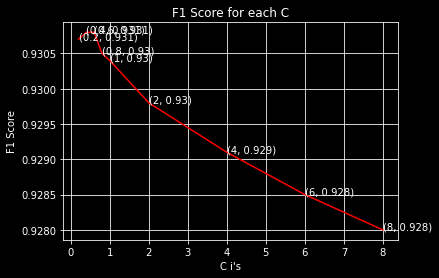

In [14]:
C = [0.2,0.4,0.6,0.8,1,2,4,6,8]
f1_scores =[]

for i in C:
    tp,fp,fn=0,0,0
    for label in targets: 
        nvsvm = NbSvmClassifier(C=i)
        model = nvsvm.fit(x_train_feature, y_train[label])
        preds = model.predict(x_test_feature)
        
        c=confusion_matrix(y_test[label], preds)
        tp+=c[1][1];fp+=c[0][1];fn+=c[1][0]
    f1_scores.append(round(2*tp/(2*tp+fp+fn),4))
    
    print(" "*7,"For C =",i,"the Micro F1-Score is ",round(2*tp/(2*tp+fp+fn),4))

# Plotting Graph for HyperParameter Tuning    
plot_hyperparameter_tuning(C,f1_scores)

           -------------------- toxic --------------------


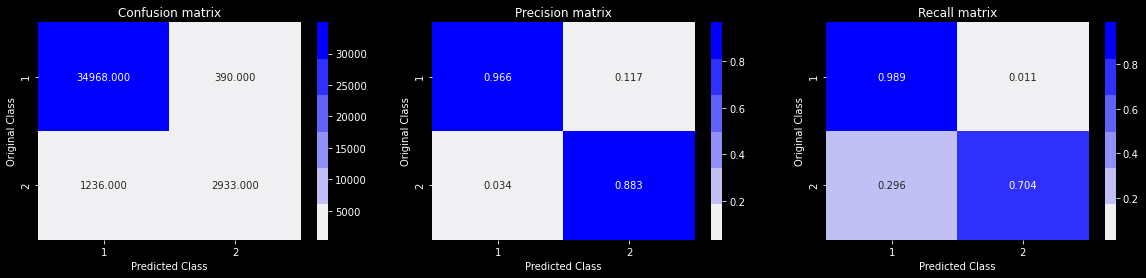

           -------------------- severe_toxic --------------------


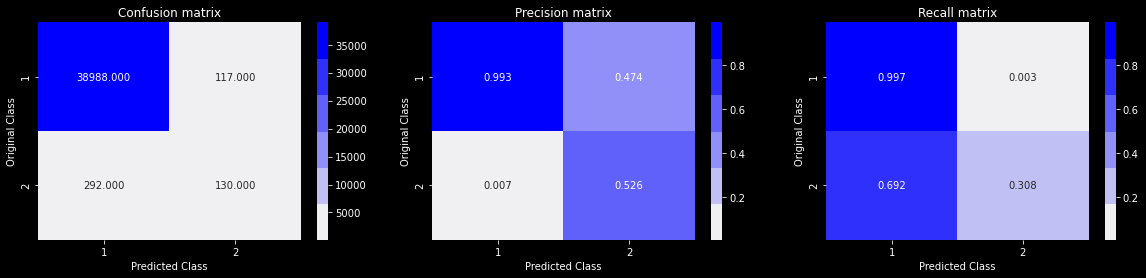

           -------------------- obscene --------------------


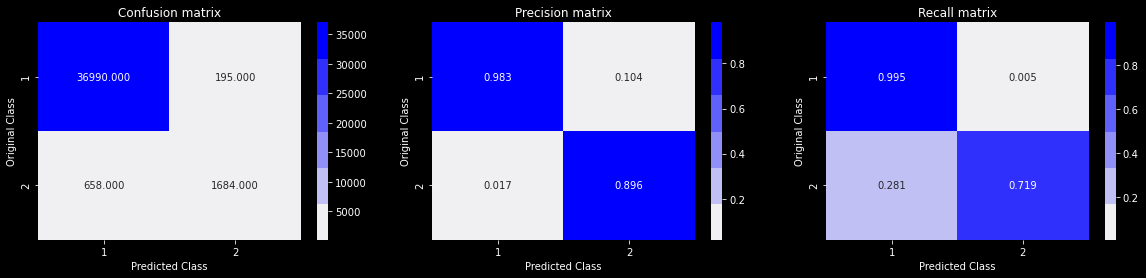

           -------------------- threat --------------------


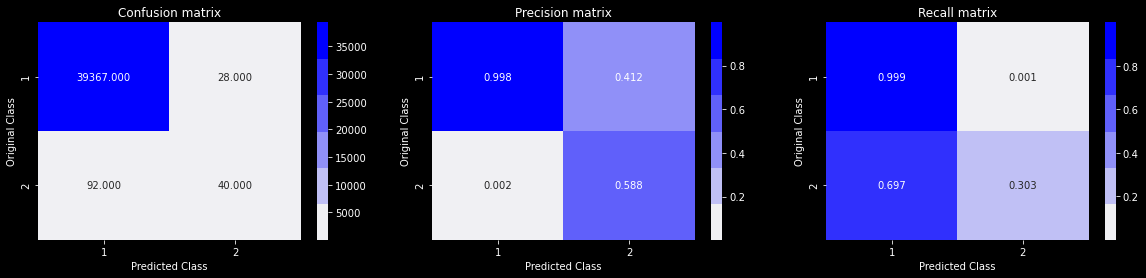

           -------------------- insult --------------------


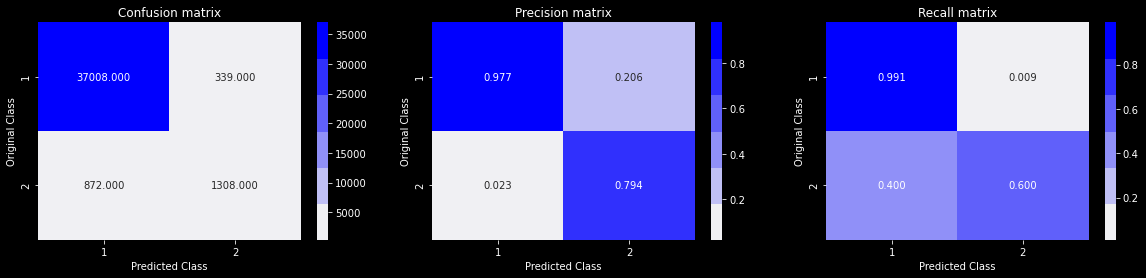

           -------------------- identity_hate --------------------


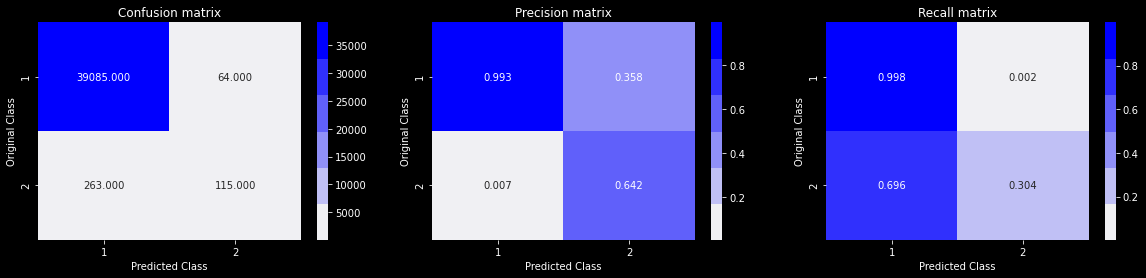

           -------------------- clean --------------------


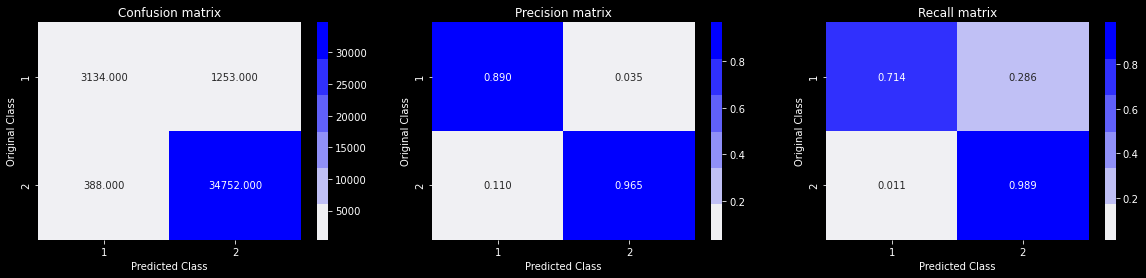

In [15]:
for label in targets: 
    print(' '*10,'-'*20,label,'-'*20)
    nvsvm = NbSvmClassifier(C=f1_scores.index(max(f1_scores))+1)
    model = nvsvm.fit(x_train_feature, y_train[label])
    preds = model.predict(x_test_feature)
    plot_confusion_matrix(y_test[label], preds)